# Use Action-Actor-Critic to Play Acrobot-v1

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow import losses
from tensorflow.keras import layers
from tensorflow.keras import models

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

21:54:57 [INFO] env: <AcrobotEnv<Acrobot-v1>>
21:54:57 [INFO] action_space: Discrete(3)
21:54:57 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
21:54:57 [INFO] reward_range: (-inf, inf)
21:54:57 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
21:54:57 [INFO] _max_episode_steps: 500
21:54:57 [INFO] _elapsed_steps: None


In [3]:
class QActorCriticAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99
        
        self.actor_net = self.build_net(hidden_sizes=[100,],
                output_size=self.action_n, output_activation=nn.softmax,
                loss=losses.categorical_crossentropy,
                learning_rate=0.0001)
        self.critic_net = self.build_net(hidden_sizes=[100,],
                output_size=self.action_n,
                learning_rate=0.0002)

    def build_net(self, hidden_sizes, output_size, input_size=None,
                activation=nn.relu, output_activation=None,
                loss=losses.mse, learning_rate=0.01):
        model = keras.Sequential()
        for hidden_size in hidden_sizes:
            model.add(layers.Dense(units=hidden_size,
                    activation=activation))
        model.add(layers.Dense(units=output_size,
                activation=output_activation))
        optimizer = optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model
        
    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.discount = 1.

    def step(self, observation, reward, done):
        probs = self.actor_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                self.learn()
            self.discount *= self.gamma
        return action

    def close(self):
        pass

    def learn(self):
        state, _, _, action, next_state, reward, done, next_action \
                = self.trajectory[-8:]
        
        # train actor
        states = state[np.newaxis]
        preds = self.critic_net.predict(states)
        q = preds[0, action]
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        with tf.GradientTape() as tape:
            pi_tensor = self.actor_net(state_tensor)[0, action]
            log_pi_tensor = tf.math.log(tf.clip_by_value(pi_tensor,
                    1e-6, 1.))
            loss_tensor = -self.discount * q * log_pi_tensor
        grad_tensors = tape.gradient(loss_tensor, self.actor_net.variables)
        self.actor_net.optimizer.apply_gradients(zip(
                grad_tensors, self.actor_net.variables))
        
        # train critic
        next_q = self.critic_net.predict(
                next_state[np.newaxis])[0, next_action]
        preds[0, action] = reward + (1. - done) * self.gamma * next_q
        self.critic_net.fit(states, preds, verbose=0)


agent = QActorCriticAgent(env)

21:54:58 [INFO] ==== train ====
21:57:40 [DEBUG] train episode 0: reward = -429.00, steps = 430
22:00:44 [DEBUG] train episode 1: reward = -500.00, steps = 500
22:03:49 [DEBUG] train episode 2: reward = -500.00, steps = 500
22:06:54 [DEBUG] train episode 3: reward = -500.00, steps = 500
22:10:00 [DEBUG] train episode 4: reward = -500.00, steps = 500
22:13:06 [DEBUG] train episode 5: reward = -500.00, steps = 500
22:16:12 [DEBUG] train episode 6: reward = -500.00, steps = 500
22:19:18 [DEBUG] train episode 7: reward = -500.00, steps = 500
22:22:32 [DEBUG] train episode 8: reward = -500.00, steps = 500
22:25:37 [DEBUG] train episode 9: reward = -464.00, steps = 465
22:28:08 [DEBUG] train episode 10: reward = -388.00, steps = 389
22:31:13 [DEBUG] train episode 11: reward = -500.00, steps = 500
22:34:15 [DEBUG] train episode 12: reward = -500.00, steps = 500
22:37:14 [DEBUG] train episode 13: reward = -500.00, steps = 500
22:39:47 [DEBUG] train episode 14: reward = -408.00, steps = 409
22:

09:12:40 [DEBUG] train episode 126: reward = -123.00, steps = 124
09:13:27 [DEBUG] train episode 127: reward = -143.00, steps = 144
09:14:10 [DEBUG] train episode 128: reward = -127.00, steps = 128
09:15:03 [DEBUG] train episode 129: reward = -157.00, steps = 158
09:16:02 [DEBUG] train episode 130: reward = -181.00, steps = 182
09:16:46 [DEBUG] train episode 131: reward = -122.00, steps = 123
09:17:32 [DEBUG] train episode 132: reward = -137.00, steps = 138
09:18:20 [DEBUG] train episode 133: reward = -132.00, steps = 133
09:19:03 [DEBUG] train episode 134: reward = -118.00, steps = 119
09:19:44 [DEBUG] train episode 135: reward = -117.00, steps = 118
09:20:36 [DEBUG] train episode 136: reward = -164.00, steps = 165
09:21:14 [DEBUG] train episode 137: reward = -118.00, steps = 119
09:22:56 [DEBUG] train episode 138: reward = -300.00, steps = 301
09:23:57 [DEBUG] train episode 139: reward = -169.00, steps = 170
09:24:44 [DEBUG] train episode 140: reward = -138.00, steps = 139
09:27:10 [

10:14:58 [DEBUG] test episode 69: reward = -109.00, steps = 110
10:15:07 [DEBUG] test episode 70: reward = -100.00, steps = 101
10:15:17 [DEBUG] test episode 71: reward = -109.00, steps = 110
10:15:28 [DEBUG] test episode 72: reward = -115.00, steps = 116
10:15:39 [DEBUG] test episode 73: reward = -114.00, steps = 115
10:15:50 [DEBUG] test episode 74: reward = -111.00, steps = 112
10:16:00 [DEBUG] test episode 75: reward = -108.00, steps = 109
10:16:13 [DEBUG] test episode 76: reward = -138.00, steps = 139
10:16:23 [DEBUG] test episode 77: reward = -106.00, steps = 107
10:16:36 [DEBUG] test episode 78: reward = -143.00, steps = 144
10:16:54 [DEBUG] test episode 79: reward = -202.00, steps = 203
10:17:06 [DEBUG] test episode 80: reward = -125.00, steps = 126
10:17:28 [DEBUG] test episode 81: reward = -238.00, steps = 239
10:17:41 [DEBUG] test episode 82: reward = -149.00, steps = 150
10:17:53 [DEBUG] test episode 83: reward = -131.00, steps = 132
10:18:06 [DEBUG] test episode 84: reward

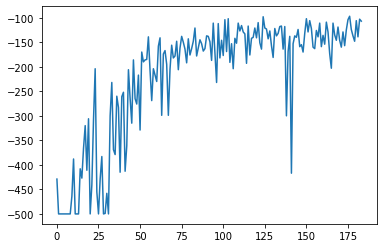

In [4]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps



logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [9]:
env.close()